In [1]:
import torch
import numpy as np
import torch.nn as nn

In [2]:
class InputEmbedding(nn.Module):

    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
    
    def forward(self, x):
        return self.embedding(x) * np.sqrt(self.d_model)

In [3]:
d_model = 512
vocab_size = 1000
I_E = InputEmbedding(d_model, vocab_size)
x = torch.randint(0, vocab_size, (2, 5)) # batch seq_len
out = I_E(x)
print(x.shape)
print(out.shape)
print(x)
print(out)

torch.Size([2, 5])
torch.Size([2, 5, 512])
tensor([[682, 473, 780, 155,  57],
        [676, 282, 842, 694, 847]])
tensor([[[-27.6642,  36.8450,  -7.1262,  ..., -22.0455,  33.5512,   7.0387],
         [ 15.5555,  -5.2621,   7.9712,  ...,  36.5307,   7.1206,   0.8030],
         [ -6.6058,  15.6181,   5.7387,  ...,  23.2371,  -1.9412, -13.2836],
         [ 22.8341,  11.8318,  10.7024,  ..., -15.6659, -10.6663,  -6.8222],
         [ 16.9108,   6.1226,  24.4039,  ...,  -5.8834,  -7.1353,   5.6481]],

        [[  1.9951, -18.6543,   2.6636,  ...,  48.7721,  46.9497,  22.9946],
         [  4.7707,  21.8098,  -2.1847,  ...,  -3.9463,  -1.8011, -18.8425],
         [ 35.0399,  33.4654,  -2.3837,  ..., -16.8742,  25.4581,  -8.2825],
         [ 21.7185,  24.6925,  11.2574,  ...,  -3.1053,  28.0998,  28.0964],
         [ 42.2394, -11.0025,   9.7838,  ..., -11.9788, -16.0104, -15.3055]]],
       grad_fn=<MulBackward0>)


In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, seq_len):
        super().__init__()
        # (seq_len, d_model)
        pe = torch.zeros((seq_len, d_model))
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        # Apply sine to even indices and cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term) # Even
        pe[:, 1::2] = torch.cos(position * div_term) # Odd
        pe = pe.unsqueeze(0)  # Add batch dimension

        self.register_buffer('pe', pe)  # Save as a non-trainable buffer

    def forward(self, x):
        # Add positional encoding to the input embeddings
        return self.pe[:, :x.size(1)]

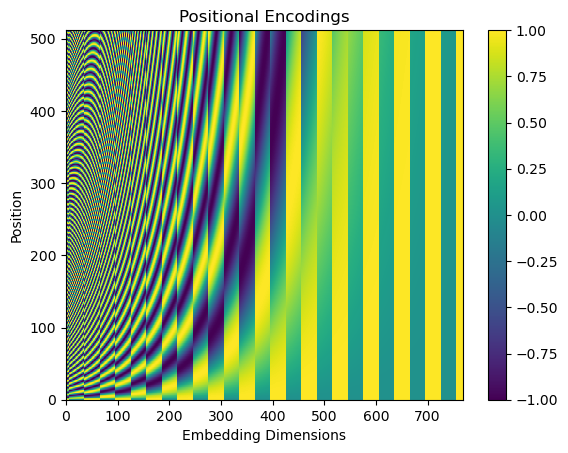

In [5]:
import matplotlib.pyplot as plt

# Example usage
d_model = 768
max_len = 512
pos_encoding = PositionalEncoding(d_model, max_len)
pos_enc = pos_encoding.pe[0, :512, :].detach().numpy()  # 512 positions
plt.pcolormesh(pos_enc, cmap='viridis')
plt.colorbar()
plt.xlabel('Embedding Dimensions')
plt.ylabel('Position')
plt.title('Positional Encodings')
plt.show()

### Self Attention

#### Traditional way to calculate embedding

In [6]:
s = "my dog name is artic and i love my dog very much"
print(s)

vocab = {j:i for i, j in enumerate(sorted(set(s.split())))}
print(vocab)

my dog name is artic and i love my dog very much
{'and': 0, 'artic': 1, 'dog': 2, 'i': 3, 'is': 4, 'love': 5, 'much': 6, 'my': 7, 'name': 8, 'very': 9}


In [7]:
## Converting to one hot encoding
x = torch.zeros(len(vocab))
print(f"{x} ## Creating X with vocab")
x[1] = 1 ## let say dog is the second word
print(f"{x} ## getting one hot for a word dog")

np.random.seed(0) ## using this because to get consistent value

## Creating embedding matrix of dog
embedding_dim = 100
embedding_matrix = np.random.randn(len(vocab), embedding_dim)
print(embedding_matrix.shape)

## Calculate the embedding matrix
word_embedding = np.dot(x, embedding_matrix)
print(word_embedding)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) ## Creating X with vocab
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]) ## getting one hot for a word dog
(10, 100)
[ 1.8831507  -1.34775906 -1.270485    0.96939671 -1.17312341  1.94362119
 -0.41361898 -0.74745481  1.92294203  1.48051479  1.86755896  0.90604466
 -0.86122569  1.91006495 -0.26800337  0.8024564   0.94725197 -0.15501009
  0.61407937  0.92220667  0.37642553 -1.09940079  0.29823817  1.3263859
 -0.69456786 -0.14963454 -0.43515355  1.84926373  0.67229476  0.40746184
 -0.76991607  0.53924919 -0.67433266  0.03183056 -0.63584608  0.67643329
  0.57659082 -0.20829876  0.39600671 -1.09306151 -1.49125759  0.4393917
  0.1666735   0.63503144  2.38314477  0.94447949 -0.91282223  1.11701629
 -1.31590741 -0.4615846  -0.06824161  1.71334272 -0.74475482 -0.82643854
 -0.09845252 -0.66347829  1.12663592 -1.07993151 -1.14746865 -0.43782004
 -0.49803245  1.92953205  0.94942081  0.08755124 -1.22543552  0.84436298
 -1.00021535 -1.5447711   1.1880

#### Calculating with torch.nn

In [8]:
s = "my dog name is artic and i love my dog very much"
print(s)

vocab = {j:i for i, j in enumerate(sorted(set(s.split())))}
print(vocab)

x = torch.tensor([vocab[i] for i in s.split()])
print(x)

my dog name is artic and i love my dog very much
{'and': 0, 'artic': 1, 'dog': 2, 'i': 3, 'is': 4, 'love': 5, 'much': 6, 'my': 7, 'name': 8, 'very': 9}
tensor([7, 2, 8, 4, 1, 0, 3, 5, 7, 2, 9, 6])


In [9]:
torch.manual_seed(0) ## this is for consistent value

embedding_dim = 100
embedding = nn.Embedding(len(vocab), embedding_dim)
embedded_sentence = embedding(x)

print(embedded_sentence)
print(embedded_sentence.shape)

tensor([[ 1.8480, -2.3950,  0.4077,  ...,  1.0945,  0.5703,  0.7764],
        [-0.0744, -1.0922,  0.3920,  ...,  0.8200, -0.6332,  1.2948],
        [-1.3568, -0.7654, -0.2090,  ..., -1.0328,  1.1305, -0.5703],
        ...,
        [-0.0744, -1.0922,  0.3920,  ...,  0.8200, -0.6332,  1.2948],
        [-2.1009,  0.3899,  0.0873,  ...,  1.4642,  0.1264, -0.5862],
        [ 0.1483,  2.4187,  1.3279,  ...,  1.0511, -1.0269, -0.2875]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([12, 100])


#### Weight Matrices and Computing 

* Explaining the query, key and value as (wq, wk, wv)

In [10]:
torch.manual_seed(0)

d = embedded_sentence.shape[1]

d_q, d_k, d_v = 24, 24, 28
## Parameter for backprop update (d_*, embedding_dim)
W_query = nn.Parameter(torch.rand(d_q, d)) 
W_key = nn.Parameter(torch.rand(d_k, d))
W_value = nn.Parameter(torch.rand(d_v, d))

In [11]:
torch.nn.Parameter(torch.rand(2,2))

Parameter containing:
tensor([[0.9957, 0.1246],
        [0.5600, 0.5973]], requires_grad=True)

In [12]:
torch.rand(2,2)

tensor([[0.5495, 0.6009],
        [0.0381, 0.0193]])

#### Lets Compute 

Just to show i am calculating just for one word (query, key, value) x embedding

In [13]:
print(f"Embedding of dog\n {embedded_sentence[1].shape}\n {embedded_sentence[1]} \n") ## this for 2nd word dog embedding

word_embed_dog = embedded_sentence[1]
## matrix multiplication between two torch.matmul
query_dog = W_query @ word_embed_dog ## (24, 100) x (100) = (d_q, embedding_dim)
print(f"query of dog {query_dog.shape}\n {query_dog} \n")

key_dog = W_key @ word_embed_dog
print(f"key of dog {key_dog.shape}\n {key_dog} \n")

value_dog = W_value @ word_embed_dog
print(f"value of dog {value_dog.shape}\n {value_dog}")

Embedding of dog
 torch.Size([100])
 tensor([-0.0744, -1.0922,  0.3920,  0.5945,  0.6623, -1.2063,  0.6074, -0.5472,
         1.1711,  0.0975,  0.9634,  0.8403, -1.2537,  0.9868, -0.4947, -1.2830,
         0.9552,  1.2836, -0.6659,  0.5651,  0.2877, -0.0334, -1.0619, -0.1144,
        -0.3433,  1.5713,  0.1916,  0.3799, -0.1448,  0.6376, -0.2813, -1.3299,
        -0.1420, -0.5341, -0.5234,  0.8615, -0.8870,  0.8388,  1.1529, -1.7611,
        -1.4777, -1.7557,  0.0762, -1.0786,  1.4403, -0.1106,  0.5769, -0.1692,
        -0.0640,  1.0384,  0.9068, -0.4755, -0.8707,  0.1447,  1.9029,  0.3904,
        -0.0394, -0.8015, -0.4955, -0.3615,  0.5851, -1.1560, -0.1434, -0.1947,
        -0.0856,  1.3945,  0.5969, -0.4828, -0.3661, -1.3271,  1.6953,  2.0655,
        -0.2340,  0.7073,  0.5800,  0.2683, -2.0589,  0.5340, -0.5354, -0.8637,
        -0.0235,  1.1717,  0.3987, -0.1987, -1.1559, -0.3167,  0.9403, -1.1470,
         0.5588,  0.7918, -0.1847, -0.7318, -0.0807, -0.9801,  0.0605, -0.4890,
   

In [14]:
word_embed_dog.shape

torch.Size([100])

Calculating for whole sentence

In [15]:
key_dog

tensor([-1.3873,  4.3065, -0.5957,  1.4955, -3.1423,  2.2467,  6.2096, -2.1757,
         5.4838,  2.8705, -1.8605,  1.3912, -1.1457,  0.6424,  1.3094,  1.1327,
         0.5142, -1.0348,  2.0825,  4.2790, -2.8594,  0.9600, -3.4238, -2.2977],
       grad_fn=<MvBackward0>)

In [16]:
## above we got the embedding we calculated earlier
(W_key @ embedded_sentence.T).T[1]

tensor([-1.3873,  4.3065, -0.5957,  1.4955, -3.1423,  2.2467,  6.2096, -2.1757,
         5.4838,  2.8705, -1.8605,  1.3912, -1.1457,  0.6424,  1.3094,  1.1327,
         0.5142, -1.0348,  2.0825,  4.2790, -2.8594,  0.9600, -3.4238, -2.2977],
       grad_fn=<SelectBackward0>)

In [17]:
## We are trasposing because we want to multiply W_key-100 dim to embedding dim to 100 x 12

keys = (W_key @ embedded_sentence.T).T # again transpose because we 12 x 100 (tokens x dim)
print(keys.shape)

values = (W_value @ embedded_sentence.T).T # again transpose because we 12 x 100 (tokens x dim)
print(values.shape)

torch.Size([12, 24])
torch.Size([12, 28])


#### Now calculating qxk

In [18]:
query_dog.dot(keys[3]) ## Using dot because multiplying two vectors and value is for 4th position token

tensor(-282.7571, grad_fn=<DotBackward0>)

In [19]:
query_dog @ (keys.T) # did matrix multiplication getting all similarity scores like dot product 

tensor([-195.6964,  -52.1381,  346.4715, -282.7571,  133.9637, -211.4562,
        -301.5111,  118.7164, -195.6964,  -52.1381,  123.6229, -203.8952],
       grad_fn=<SqueezeBackward4>)

In [20]:
omega_dog = query_dog @ keys.T

In [21]:
## +1 just to print token 
print(f"Most similar word for dog is {torch.argmax(omega_dog) + 1}rd token with score of {max(omega_dog)}")

Most similar word for dog is 3rd token with score of 346.47149658203125


#### Scaled-Dot Product

Now we have to normalized the attention by scaling softmax(Q.(K.T)) / sqrt(d_k) <br>
we are doing this because to get Gradient Stability (Vanishing Gradient and smooth training)

In [22]:
import torch.nn.functional as F

since the attention values were unnormlized that's why we need to normilize it

In [23]:
omega_dog / np.sqrt(d_k)  

tensor([-39.9464, -10.6426,  70.7232, -57.7176,  27.3452, -43.1633, -61.5457,
         24.2329, -39.9464, -10.6426,  25.2344, -41.6199],
       grad_fn=<DivBackward0>)

In [24]:
F.softmax(omega_dog / np.sqrt(d_k))

C:\Users\Aquib\AppData\Local\Temp\ipykernel_16708\2513399052.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(omega_dog / np.sqrt(d_k))


tensor([0.0000e+00, 4.6053e-36, 1.0000e+00, 0.0000e+00, 1.4494e-19, 0.0000e+00,
        0.0000e+00, 6.4493e-21, 0.0000e+00, 4.6053e-36, 1.7558e-20, 0.0000e+00],
       grad_fn=<SoftmaxBackward0>)

In [25]:
## See it throws a warning although it is row vector thats why we need to include dim=0 as row
attention_weight_dog = F.softmax(omega_dog / np.sqrt(d_k), dim=0)
print(attention_weight_dog.shape)

torch.Size([12])


In [26]:
## Using Functional because it is function
F.softmax(omega_dog / np.sqrt(d_k), dim=0)

tensor([0.0000e+00, 4.6053e-36, 1.0000e+00, 0.0000e+00, 1.4494e-19, 0.0000e+00,
        0.0000e+00, 6.4493e-21, 0.0000e+00, 4.6053e-36, 1.7558e-20, 0.0000e+00],
       grad_fn=<SoftmaxBackward0>)

In [27]:
## in this we are using it as a layer s = nn.Softmax() then passing value
s = nn.Softmax(dim=0)
s(omega_dog / np.sqrt(d_k))

tensor([0.0000e+00, 4.6053e-36, 1.0000e+00, 0.0000e+00, 1.4494e-19, 0.0000e+00,
        0.0000e+00, 6.4493e-21, 0.0000e+00, 4.6053e-36, 1.7558e-20, 0.0000e+00],
       grad_fn=<SoftmaxBackward0>)

Now all the operations are completed lastly multiply it with values to get context vectors

In [28]:
context_vector_dog = attention_weight_dog @ values

print(context_vector_dog)
print(context_vector_dog.shape, values.shape)

tensor([-12.7831,  -8.3603, -13.3140, -14.0631, -11.1726,  -5.3289,  -9.4512,
         -4.7065,  -6.7364,  -6.9353,  -9.7753,  -7.4746,  -8.0532,  -6.3220,
        -10.5533,  -9.5065,  -8.8039,  -9.8735, -11.0426, -11.4688, -11.2285,
         -5.5606, -13.3809,  -9.0744, -10.6953,  -8.6092, -12.8470,  -3.8284],
       grad_fn=<SqueezeBackward4>)
torch.Size([28]) torch.Size([12, 28])


### Multi Head Attention

In [29]:
embedded_sentence

tensor([[ 1.8480, -2.3950,  0.4077,  ...,  1.0945,  0.5703,  0.7764],
        [-0.0744, -1.0922,  0.3920,  ...,  0.8200, -0.6332,  1.2948],
        [-1.3568, -0.7654, -0.2090,  ..., -1.0328,  1.1305, -0.5703],
        ...,
        [-0.0744, -1.0922,  0.3920,  ...,  0.8200, -0.6332,  1.2948],
        [-2.1009,  0.3899,  0.0873,  ...,  1.4642,  0.1264, -0.5862],
        [ 0.1483,  2.4187,  1.3279,  ...,  1.0511, -1.0269, -0.2875]],
       grad_fn=<EmbeddingBackward0>)

In [31]:
d_q, d_k, d_v = 24, 24, 28
h = 3 
d = embedded_sentence.shape[1]

multihead_W_query = torch.nn.Parameter(torch.rand(h, d_q, d))
multihead_W_key = torch.nn.Parameter(torch.rand(h, d_k, d))
multihead_W_value = torch.nn.Parameter(torch.rand(h, d_v, d))

print(multihead_W_key.shape, multihead_W_key)

torch.Size([3, 24, 100]) Parameter containing:
tensor([[[0.5388, 0.0155, 0.7236,  ..., 0.3220, 0.4040, 0.9695],
         [0.8005, 0.1437, 0.8109,  ..., 0.0940, 0.8791, 0.5910],
         [0.4773, 0.8000, 0.5560,  ..., 0.0470, 0.5827, 0.5011],
         ...,
         [0.6600, 0.3810, 0.2615,  ..., 0.7348, 0.9654, 0.4431],
         [0.0631, 0.9067, 0.0484,  ..., 0.8959, 0.3652, 0.9990],
         [0.1877, 0.0989, 0.1682,  ..., 0.4486, 0.9962, 0.2074]],

        [[0.7362, 0.2519, 0.0175,  ..., 0.7434, 0.8148, 0.4186],
         [0.4622, 0.0970, 0.1317,  ..., 0.4620, 0.5921, 0.1375],
         [0.4224, 0.6134, 0.1630,  ..., 0.8940, 0.8018, 0.2709],
         ...,
         [0.5031, 0.0718, 0.1666,  ..., 0.5281, 0.2995, 0.2435],
         [0.2587, 0.4390, 0.3708,  ..., 0.5385, 0.5571, 0.5548],
         [0.4227, 0.5123, 0.6871,  ..., 0.7028, 0.4762, 0.2286]],

        [[0.0682, 0.5980, 0.6669,  ..., 0.3461, 0.2294, 0.2601],
         [0.1080, 0.7848, 0.5947,  ..., 0.6710, 0.9939, 0.8047],
         [0

In [41]:
multihead_query_2  = multihead_W_query @ word_embed_dog
print(multihead_query_2.shape)

multihead_key_2 = multihead_W_key @ word_embed_dog
print(multihead_key_2.shape)

multihead_value_2 = multihead_W_value @ word_embed_dog
print(multihead_value_2.shape)

torch.Size([3, 24])
torch.Size([3, 24])
torch.Size([3, 28])


Expanding the input sequence embeddings to size 3, i.e., the number of attention heads:

In [50]:
stacked_inputs = embedded_sentence.T.repeat(3, 1, 1)
print(stacked_inputs.shape)

torch.Size([3, 100, 12])


In [52]:
# torch.bmm() ( batch matrix multiplication)
multihead_keys = torch.bmm(multihead_W_key, stacked_inputs)
multihead_values = torch.bmm(multihead_W_value, stacked_inputs)
print("multihead_keys.shape:", multihead_keys.shape)
print("multihead_values.shape:", multihead_values.shape)

## we have three attention heads in their first dimension, third and second dimensions refer to the number of words and the embedding size
## we will swap the second and third dimensions, resulting in tensors with the same dimensional structure as the original input sequence
print("\n")
multihead_keys = multihead_keys.permute(0, 2, 1)
multihead_values = multihead_values.permute(0, 2, 1)
print("multihead_keys.shape:", multihead_keys.shape)
print("multihead_values.shape:", multihead_values.shape)

multihead_keys.shape: torch.Size([3, 24, 12])
multihead_values.shape: torch.Size([3, 28, 12])


multihead_keys.shape: torch.Size([3, 12, 24])
multihead_values.shape: torch.Size([3, 12, 28])


In [53]:
# embedded_sentence.unsqueeze(0).shape
embd = embedded_sentence.unsqueeze(0)

In [54]:
embd.shape

torch.Size([1, 12, 100])

Step 1: Linear Projections<br>
Apply linear transformations to obtain 
𝑄, 𝐾, 𝑉

In [55]:
q_linear = nn.Linear(100, 100)
k_linear = nn.Linear(100, 100)
v_linear = nn.Linear(100, 100)

In [56]:
Q = q_linear(embd)
K = k_linear(embd)
V = v_linear(embd)

Step 2: Reshape and Transpose<br> Split 𝑄, 𝐾, 𝑉 into multiple heads and rearrange dimensions

In [57]:
batch = Q.size(0)
seq_len = Q.size(1)
num_heads = 2
head_dim = Q.size(2) // num_heads # d_model(embeddng dim) % num-heads == 0

## head_dim = 50
## (batch, seqlen, embedding_dim) --> (batch, num_heads, seqlen, head_dim)
Q_split = Q.view(batch, seq_len, num_heads, head_dim).transpose(1, 2)
K_split = K.view(batch, seq_len, num_heads, head_dim).transpose(1, 2)
V_split = V.view(batch, seq_len, num_heads, head_dim).transpose(1, 2)

print(f"Previously shape was {Q.shape} now it is shaped {Q_split.shape}")

Previously shape was torch.Size([1, 12, 100]) now it is shaped torch.Size([1, 2, 12, 50])


Step 3: Scaled Dot-Product Attention <br>
Compute attention scores and weighted values:

In [58]:
scale = np.sqrt(head_dim) ## 50 ** 0.5
print(f"Scaled value of which will be divided is {scale}\n")

scores = (Q_split @ K_split.transpose(-2, -1)) / scale # (batch_size, num_heads, seq_len, seq_len)
print(f"Q shape is: {Q_split.shape}, K shape after transformation is: {K_split.transpose(-2, -1).shape}\n")
print(f"Scores shape is {scores.shape}")

Scaled value of which will be divided is 7.0710678118654755

Q shape is: torch.Size([1, 2, 12, 50]), K shape after transformation is: torch.Size([1, 2, 50, 12])

Scores shape is torch.Size([1, 2, 12, 12])


In [59]:
attention_weight = torch.softmax(scores, dim=-1)
print(f"Attention Weight shape is {attention_weight.shape}")

attention_output = attention_weight @ V_split
print(f"Attention Output shape is {attention_output.shape}")

Attention Weight shape is torch.Size([1, 2, 12, 12])
Attention Output shape is torch.Size([1, 2, 12, 50])


In [60]:
print(attention_output.transpose(1, 2).shape)
print(attention_output.shape)

torch.Size([1, 12, 2, 50])
torch.Size([1, 2, 12, 50])


Step 4: Concatenate Heads <br>
Rearrange dimensions to concatenate heads and reshape to original size:

In [61]:
attention_output_concat = attention_output.transpose(1, 2).contiguous().view(batch, seq_len, 100)  # (batch_size, seq_len, d_model)
print(attention_output_concat.shape)

torch.Size([1, 12, 100])


Step 5: Final Linear Transformation <br>
Apply the output linear transformation:

In [62]:
out_linear = nn.Linear(100, 100)
output = out_linear(attention_output_concat)  # (batch_size, seq_len, d_model)
print(output.shape)

torch.Size([1, 12, 100])


### Cross-Attention

In [76]:
d = embedded_sentence.shape[1]
print("embedded_sentence.shape:", embedded_sentence.shape)

d_q, d_k, d_v = 24, 24, 28

W_query = torch.rand(d_q, d)
W_key = torch.rand(d_k, d)
W_value = torch.rand(d_v, d)

query_2 = W_query @ word_embed_dog
key_2 = W_key @ word_embed_dog
value_2 = W_value @ word_embed_dog

print("query.shape", query_2.shape)
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

embedded_sentence.shape: torch.Size([12, 100])
query.shape torch.Size([24])
keys.shape: torch.Size([12, 24])
values.shape: torch.Size([12, 28])


In [72]:
(W_query @ word_embed_dog).shape

torch.Size([24])

### Layer Normalization

In [93]:
class LayerNormalization(nn.Module):

    def __init__(self, d_model, epsilon=1e-5):
        super().__init__()
        self.eps = epsilon
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
    
    def forward(self, x):
        # Compute mean and variance along the last dimension (feature dimension)
        mean = x.mean(dim=-1, keepdim=True) # Shape: (batch_size, seq_len, 1)
        variance = x.var(dim=-1, keepdim=True)

        # Normalized
        x_norm = (x - mean) / torch.sqrt(variance + self.eps)

        # Scale and Shift
        output =  self.gamma * x_norm + self.beta
        return output


In [100]:
LN = LayerNormalization(100)
output_norm = LN(output)

print(f"Previous it was:\n {output}\n\n Now it is:\n {output_norm}")

Previous it was:
 tensor([[[ 0.0442, -0.0423,  0.0673,  ...,  0.0823, -0.0869,  0.0577],
         [ 0.0384,  0.0150, -0.0065,  ...,  0.1221, -0.0731, -0.0453],
         [-0.0280, -0.0996,  0.0316,  ...,  0.0065, -0.1399, -0.0577],
         ...,
         [ 0.0384,  0.0150, -0.0065,  ...,  0.1221, -0.0731, -0.0453],
         [ 0.0017,  0.0003, -0.0042,  ...,  0.0733, -0.0658, -0.0228],
         [-0.0183,  0.0615,  0.0051,  ...,  0.1212, -0.0408,  0.0117]]],
       grad_fn=<ViewBackward0>)

 Now it is:
 tensor([[[ 0.2376, -0.4267,  0.4153,  ...,  0.5303, -0.7693,  0.3410],
         [ 0.1750,  0.0096, -0.1427,  ...,  0.7675, -0.6138, -0.4170],
         [-0.2071, -0.7047,  0.2071,  ...,  0.0327, -0.9852, -0.4134],
         ...,
         [ 0.1750,  0.0096, -0.1427,  ...,  0.7675, -0.6138, -0.4170],
         [-0.0708, -0.0815, -0.1167,  ...,  0.4786, -0.5892, -0.2593],
         [-0.2850,  0.2989, -0.1139,  ...,  0.7353, -0.4498, -0.0657]]],
       grad_fn=<AddBackward0>)


### Point-wise Feed Forward

In [107]:
class PointwiseFeedForward(nn.Module):

    def __init__(self, d_model, d_hidden):
        super().__init__()
        self.linear_w_1 = nn.Linear(d_model, d_hidden)
        self.linear_w_2 = nn.Linear(d_hidden, d_model)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear_w_1(x)
        x = self.relu(x)
        x = self.linear_w_2(x)
        return x

In [110]:
PFFN = PointwiseFeedForward(100, 50)
output = PFFN(output_norm)
print(f"Previous it was:\n {output_norm}\n\n Now it is:\n {output}")

Previous it was:
 tensor([[[ 0.2376, -0.4267,  0.4153,  ...,  0.5303, -0.7693,  0.3410],
         [ 0.1750,  0.0096, -0.1427,  ...,  0.7675, -0.6138, -0.4170],
         [-0.2071, -0.7047,  0.2071,  ...,  0.0327, -0.9852, -0.4134],
         ...,
         [ 0.1750,  0.0096, -0.1427,  ...,  0.7675, -0.6138, -0.4170],
         [-0.0708, -0.0815, -0.1167,  ...,  0.4786, -0.5892, -0.2593],
         [-0.2850,  0.2989, -0.1139,  ...,  0.7353, -0.4498, -0.0657]]],
       grad_fn=<AddBackward0>)

 Now it is:
 tensor([[[ 0.2062,  0.0705,  0.2170,  ...,  0.4555, -0.1811, -0.2347],
         [ 0.2173,  0.1219,  0.1527,  ...,  0.4928, -0.1224, -0.3307],
         [ 0.0748,  0.0694,  0.3618,  ...,  0.5261, -0.0784, -0.2218],
         ...,
         [ 0.2173,  0.1219,  0.1527,  ...,  0.4928, -0.1224, -0.3307],
         [ 0.2003,  0.0897,  0.1829,  ...,  0.5394, -0.0580, -0.3013],
         [ 0.2313,  0.0309,  0.0778,  ...,  0.5490, -0.0275, -0.2995]]],
       grad_fn=<ViewBackward0>)
